In [165]:
# import library
import matplotlib
matplotlib.use('Agg')
import tensorflow as tf
import numpy as np
import sys, os,cv2
from scipy.misc import imread,imresize
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from imgaug import augmenters as iaa
import imgaug as ia
from scipy.ndimage import zoom
from sklearn.utils import shuffle
import matplotlib.animation as animation
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_blobs,make_moons,make_swiss_roll
from IPython.display  import IFrame

plt.style.use('seaborn')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'nbAgg' by the following code:
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado

In [119]:
# create function for PCA using SVD
def pca_svd(data,return_project = False,mmax=1.5,mmin=0.5):
    data  = data - data.mean(0,keepdims=True)
    U,S,V = np.linalg.svd(data,full_matrices=False)
    projected_data = U @ np.diag(S) 
    V_T = V.T
    s_range = (mmax-mmin) * (S-S.min())/(S.max()-S.min()) + mmin
    if not return_project: return V_T,s_range
    return projected_data,V_T,s_range

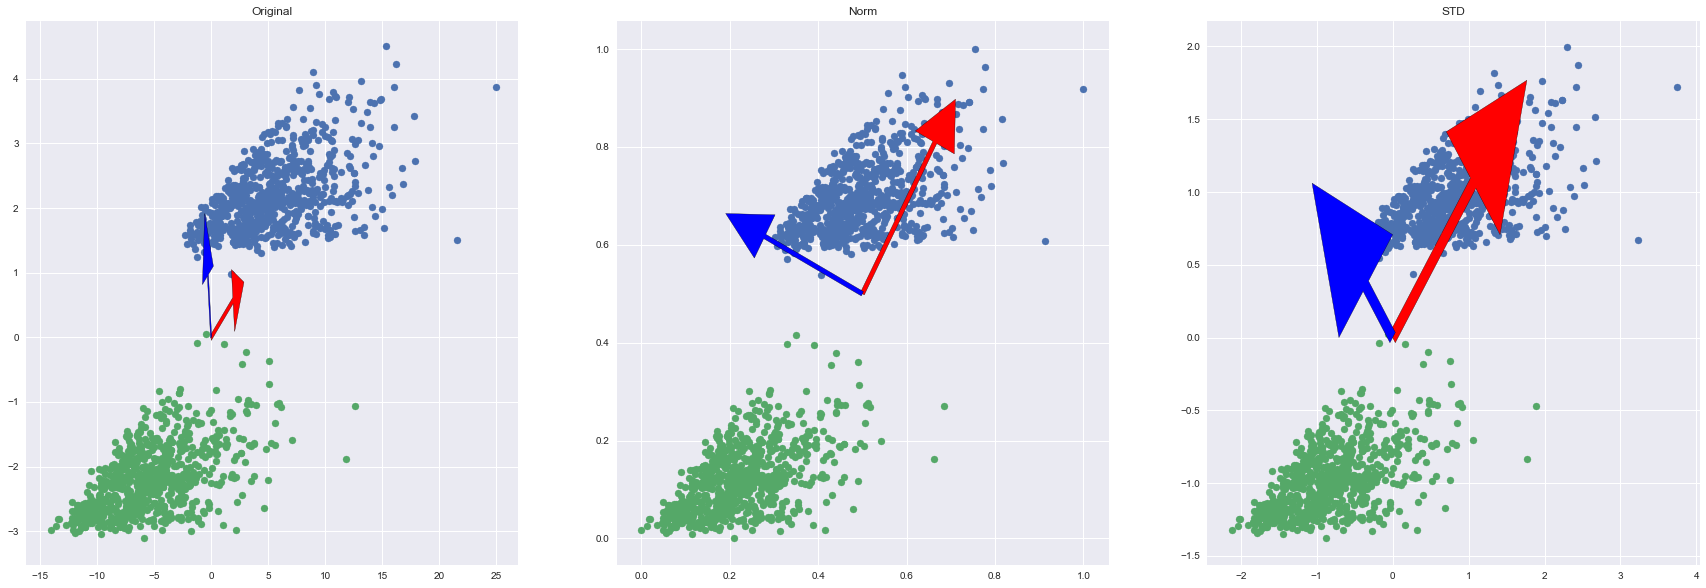

In [141]:
# make circle original data
from sklearn import  datasets
np.random.seed(6789)
data,label  = datasets.make_blobs(n_samples=n_samples,cluster_std=0.3,centers=2)
data = data + np.random.poisson(size=data.shape)
transformation = np.asarray([[2,0.5],[3.2,0]])
data = data @ transformation
data = data - data.mean(0,keepdims=True)

# normalize and standardize
data_normalized = (data-data.min( 0,keepdims=True))/(data.max(0,keepdims=True)-data.min(0,keepdims=True))
data_std        = (data-data.mean(0,keepdims=True))/(data.std(0,keepdims=True))

og_vec,og_val = pca_svd(data,mmax=2,mmin=1)
no_vec,no_val = pca_svd(data_normalized,mmax=0.35,mmin=0.25)
st_vec,st_val = pca_svd(data_std)

plt.figure(figsize=(30,10))
plt.subplot(131); plt.title('Original')
plt.scatter(data[label==0,0],data[label==0,1]);           
plt.scatter(data[label==1,0],data[label==1,1]); 
plt.arrow(0,0,*og_vec[:,0]*og_val[0],length_includes_head = False,color='Red',  ec="k", head_width=1, head_length=1,width=0.1);                   
plt.arrow(0,0,*og_vec[:,1]*og_val[1],length_includes_head = False,color='Blue', ec="k", head_width=1, head_length=1,width=0.1);

plt.subplot(132); plt.title('Norm')
plt.scatter(data_normalized[label==0,0],data_normalized[label==0,1]); 
plt.scatter(data_normalized[label==1,0],data_normalized[label==1,1]);
plt.arrow(0.5,0.5,*no_vec[:,0]*no_val[0],length_includes_head = False,color='Red',  ec="k", head_width=0.1, head_length=0.1,width=0.01);                   
plt.arrow(0.5,0.5,*no_vec[:,1]*no_val[1],length_includes_head = False,color='Blue', ec="k", head_width=0.1, head_length=0.1,width=0.01);

plt.subplot(133); plt.title('STD')
plt.scatter(data_std[label==0,0],data_std[label==0,1]); 
plt.scatter(data_std[label==1,0],data_std[label==1,1]); 
plt.arrow(0,0,*st_vec[:,0]*st_val[0],length_includes_head = False,color='Red',  ec="k", head_width=1, head_length=1,width=0.1);                   
plt.arrow(0,0,*st_vec[:,1]*st_val[1],length_includes_head = False,color='Blue', ec="k", head_width=1, head_length=1,width=0.1);

plt.show()

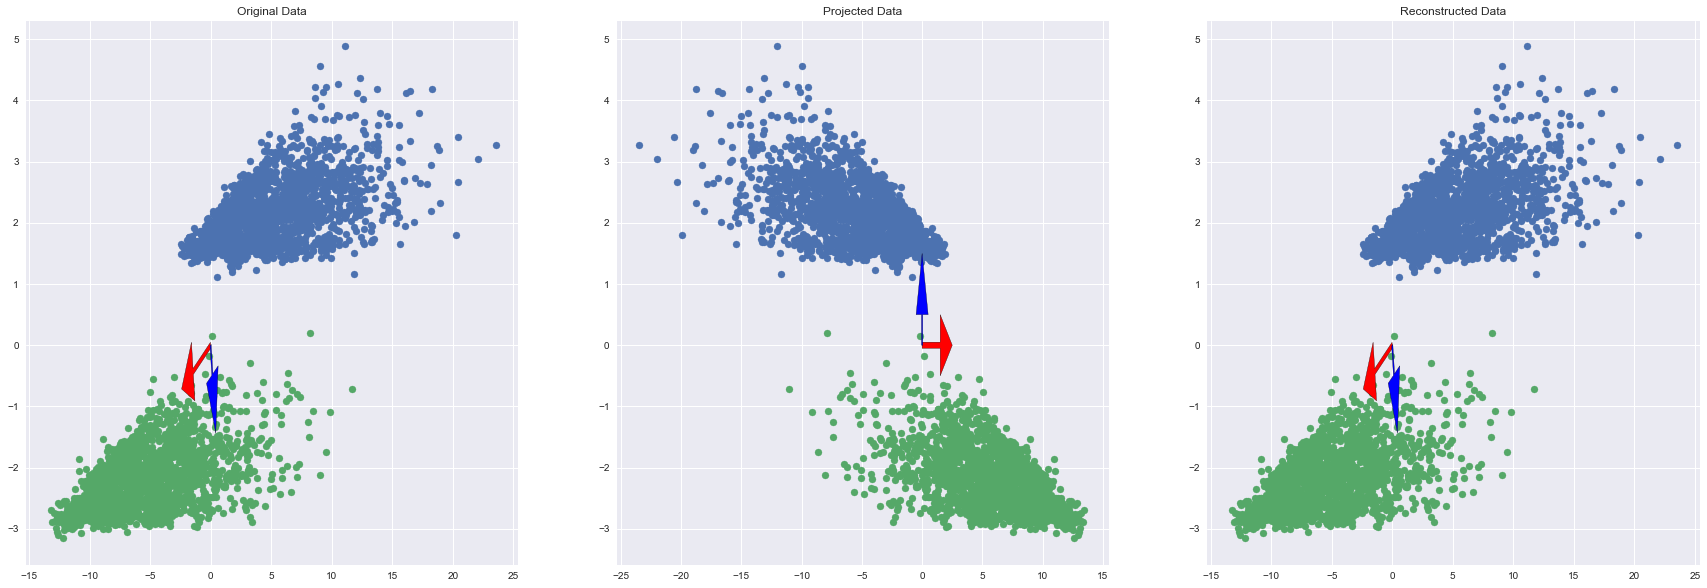

In [122]:
# Regular PCA and Back to it
og_vec,og_val = pca_svd(data)

projected_data = data  @ og_vec
pj_vec,pj_val  = pca_svd(projected_data)

reconstructdata= projected_data @ og_vec.T
rc_vec,rc_val  = pca_svd(reconstructdata)

plt.figure(figsize=(30,10))
plt.subplot(131); plt.title('Original Data')
plt.scatter(data[label==0,0],data[label==0,1]);     
plt.scatter(data[label==1,0],data[label==1,1])
plt.arrow(0,0,*og_vec[:,0]*og_val[0],length_includes_head = False,color='Red',  ec="k", head_width=1, head_length=1,width=0.1);                   
plt.arrow(0,0,*og_vec[:,1]*og_val[1],length_includes_head = False,color='Blue', ec="k", head_width=1, head_length=1,width=0.1);

plt.subplot(132); plt.title('Projected Data')
plt.scatter(projected_data[label==0,0],data[label==0,1]); plt.scatter(projected_data[label==1,0],data[label==1,1])
plt.arrow(0,0,*pj_vec[:,0]*pj_val[0],length_includes_head = False,color='Red',  ec="k", head_width=1, head_length=1,width=0.1);                   
plt.arrow(0,0,*pj_vec[:,1]*pj_val[1],length_includes_head = False,color='Blue', ec="k", head_width=1, head_length=1,width=0.1);

plt.subplot(133); plt.title('Reconstructed Data')
plt.scatter(reconstructdata[label==0,0],data[label==0,1]); plt.scatter(reconstructdata[label==1,0],data[label==1,1])
plt.arrow(0,0,*rc_vec[:,0]*rc_val[0],length_includes_head = False,color='Red',  ec="k", head_width=1, head_length=1,width=0.1);                   
plt.arrow(0,0,*rc_vec[:,1]*rc_val[1],length_includes_head = False,color='Blue', ec="k", head_width=1, head_length=1,width=0.1);

plt.show()

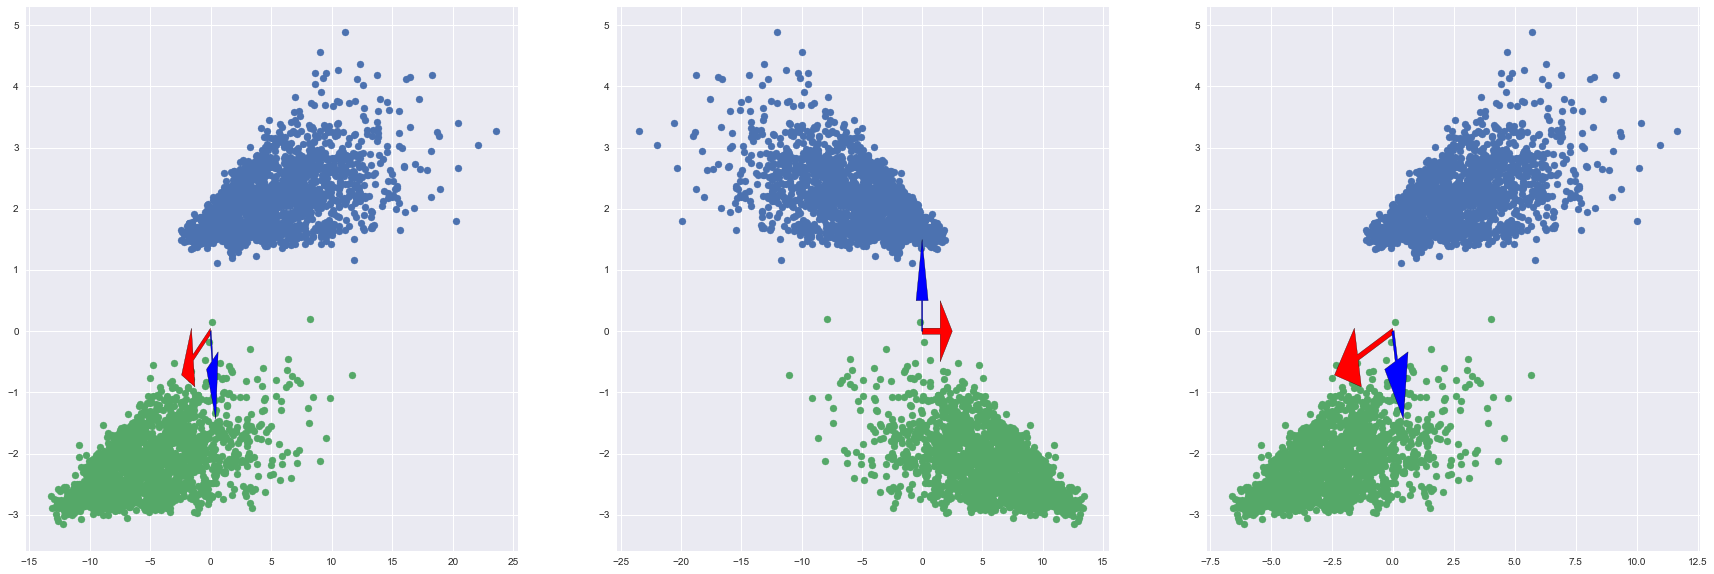

In [123]:
# now fun with pca
og_vec, og_val = pca_svd(data)

projected_data = data @ og_vec
pj_vec,pj_val  = pca_svd(projected_data)

og_vec_value   = og_vec * og_val
og_vec_value   = og_vec * og_vec_value.std(0,keepdims=True)

reconstructdata= projected_data @ og_vec_value.T
rc_vec,rc_val  = pca_svd(reconstructdata)

plt.figure(figsize=(30,10))
plt.subplot(131); 
plt.scatter(data[label==0,0],data[label==0,1]);     
plt.scatter(data[label==1,0],data[label==1,1])
plt.arrow(0,0,*og_vec[:,0]*og_val[0],length_includes_head = False,color='Red',  ec="k", head_width=1, head_length=1,width=0.1);                   
plt.arrow(0,0,*og_vec[:,1]*og_val[1],length_includes_head = False,color='Blue', ec="k", head_width=1, head_length=1,width=0.1);

plt.subplot(132); 
plt.scatter(projected_data[label==0,0],data[label==0,1]); plt.scatter(projected_data[label==1,0],data[label==1,1])
plt.arrow(0,0,*pj_vec[:,0]*pj_val[0],length_includes_head = False,color='Red',  ec="k", head_width=1, head_length=1,width=0.1);                   
plt.arrow(0,0,*pj_vec[:,1]*pj_val[1],length_includes_head = False,color='Blue', ec="k", head_width=1, head_length=1,width=0.1);

plt.subplot(133); 
plt.scatter(reconstructdata[label==0,0],data[label==0,1]); plt.scatter(reconstructdata[label==1,0],data[label==1,1])
plt.arrow(0,0,*rc_vec[:,0]*rc_val[0],length_includes_head = False,color='Red',  ec="k", head_width=1, head_length=1,width=0.1);                   
plt.arrow(0,0,*rc_vec[:,1]*rc_val[1],length_includes_head = False,color='Blue', ec="k", head_width=1, head_length=1,width=0.1);

plt.show()

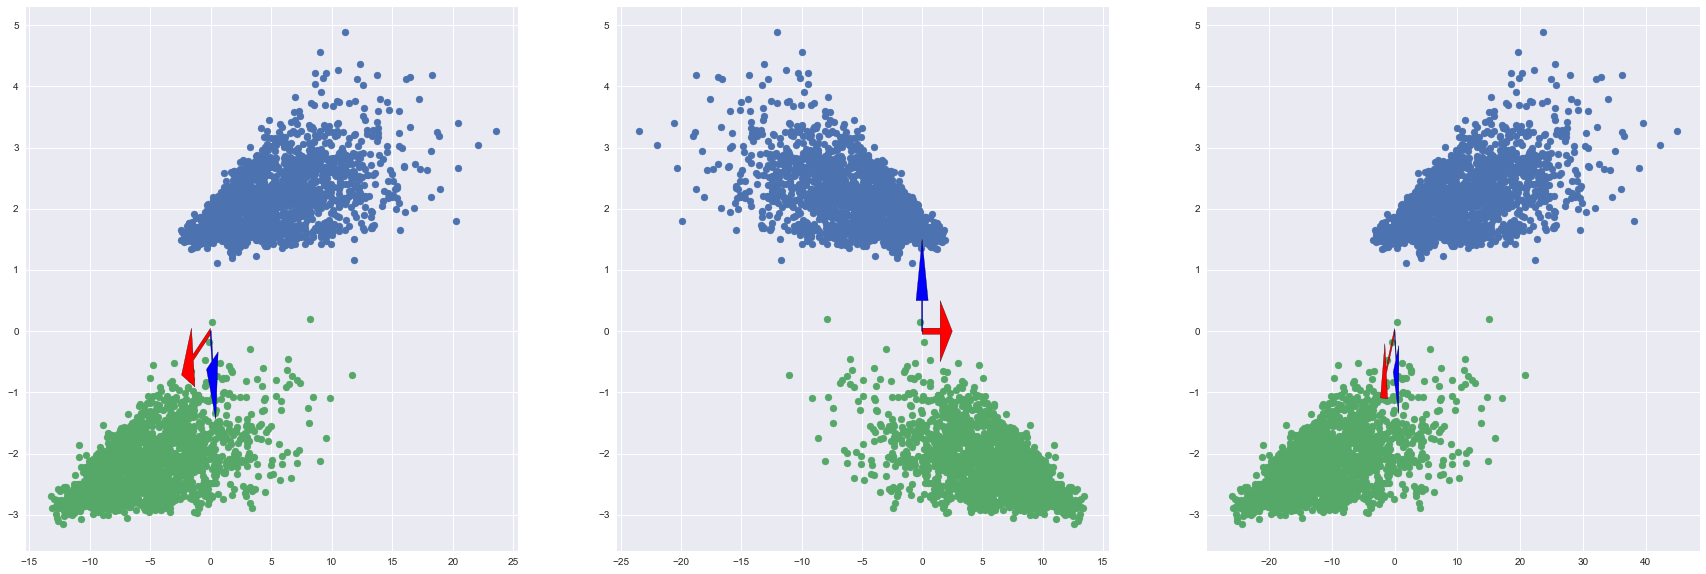

In [124]:
# now fun with pca subtract std
og_vec, og_val = pca_svd(data)

projected_data = data @ og_vec
pj_vec,pj_val  = pca_svd(projected_data)

og_vec_value   = og_vec * og_val
og_vec_mean    = og_vec_value - og_vec_value.std(0,keepdims=True)

reconstructdata= projected_data @ og_vec_mean.T
rc_vec,rc_val  = pca_svd(reconstructdata)

plt.figure(figsize=(30,10))
plt.subplot(131); 
plt.scatter(data[label==0,0],data[label==0,1]);     
plt.scatter(data[label==1,0],data[label==1,1])
plt.arrow(0,0,*og_vec[:,0]*og_val[0],length_includes_head = False,color='Red',  ec="k", head_width=1, head_length=1,width=0.1);                   
plt.arrow(0,0,*og_vec[:,1]*og_val[1],length_includes_head = False,color='Blue', ec="k", head_width=1, head_length=1,width=0.1);

plt.subplot(132); 
plt.scatter(projected_data[label==0,0],data[label==0,1]); plt.scatter(projected_data[label==1,0],data[label==1,1])
plt.arrow(0,0,*pj_vec[:,0]*pj_val[0],length_includes_head = False,color='Red',  ec="k", head_width=1, head_length=1,width=0.1);                   
plt.arrow(0,0,*pj_vec[:,1]*pj_val[1],length_includes_head = False,color='Blue', ec="k", head_width=1, head_length=1,width=0.1);

plt.subplot(133); 
plt.scatter(reconstructdata[label==0,0],data[label==0,1]); plt.scatter(reconstructdata[label==1,0],data[label==1,1])
plt.arrow(0,0,*rc_vec[:,0]*rc_val[0],length_includes_head = False,color='Red',  ec="k", head_width=1, head_length=1,width=0.1);                   
plt.arrow(0,0,*rc_vec[:,1]*rc_val[1],length_includes_head = False,color='Blue', ec="k", head_width=1, head_length=1,width=0.1);

plt.show()

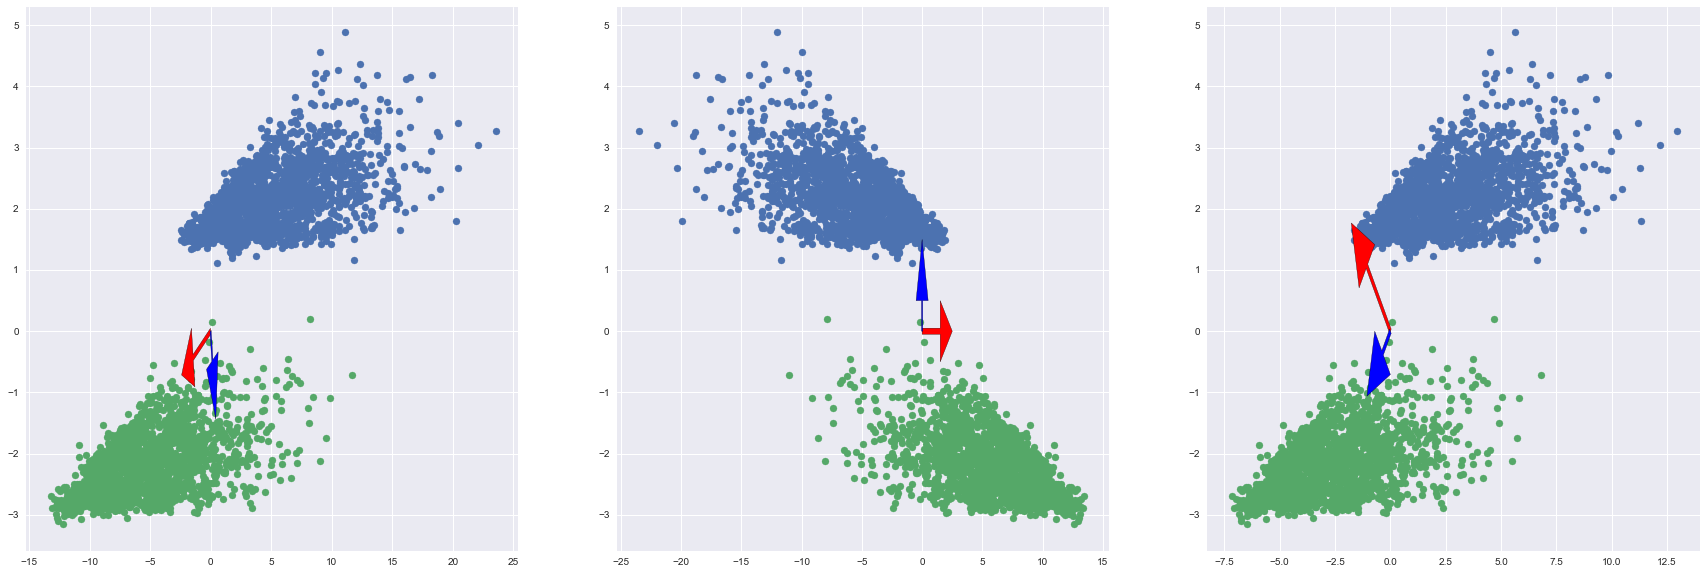

In [125]:
# now fun with pca 
og_vec, og_val = pca_svd(data)

projected_data = data @ og_vec
pj_vec,pj_val  = pca_svd(projected_data)

og_vec_value   = og_vec * og_val
og_vec_mean    = og_vec_value - og_vec_value.mean(0,keepdims=True)

reconstructdata= projected_data @ og_vec_mean.T
rc_vec,rc_val  = pca_svd(reconstructdata)

plt.figure(figsize=(30,10))
plt.subplot(131); 
plt.scatter(data[label==0,0],data[label==0,1]);     
plt.scatter(data[label==1,0],data[label==1,1])
plt.arrow(0,0,*og_vec[:,0]*og_val[0],length_includes_head = False,color='Red',  ec="k", head_width=1, head_length=1,width=0.1);                   
plt.arrow(0,0,*og_vec[:,1]*og_val[1],length_includes_head = False,color='Blue', ec="k", head_width=1, head_length=1,width=0.1);

plt.subplot(132); 
plt.scatter(projected_data[label==0,0],data[label==0,1]); plt.scatter(projected_data[label==1,0],data[label==1,1])
plt.arrow(0,0,*pj_vec[:,0]*pj_val[0],length_includes_head = False,color='Red',  ec="k", head_width=1, head_length=1,width=0.1);                   
plt.arrow(0,0,*pj_vec[:,1]*pj_val[1],length_includes_head = False,color='Blue', ec="k", head_width=1, head_length=1,width=0.1);

plt.subplot(133); 
plt.scatter(reconstructdata[label==0,0],data[label==0,1]); plt.scatter(reconstructdata[label==1,0],data[label==1,1])
plt.arrow(0,0,*rc_vec[:,0]*rc_val[0],length_includes_head = False,color='Red',  ec="k", head_width=1, head_length=1,width=0.1);                   
plt.arrow(0,0,*rc_vec[:,1]*rc_val[1],length_includes_head = False,color='Blue', ec="k", head_width=1, head_length=1,width=0.1);

plt.show()

# ==========================================================================================================

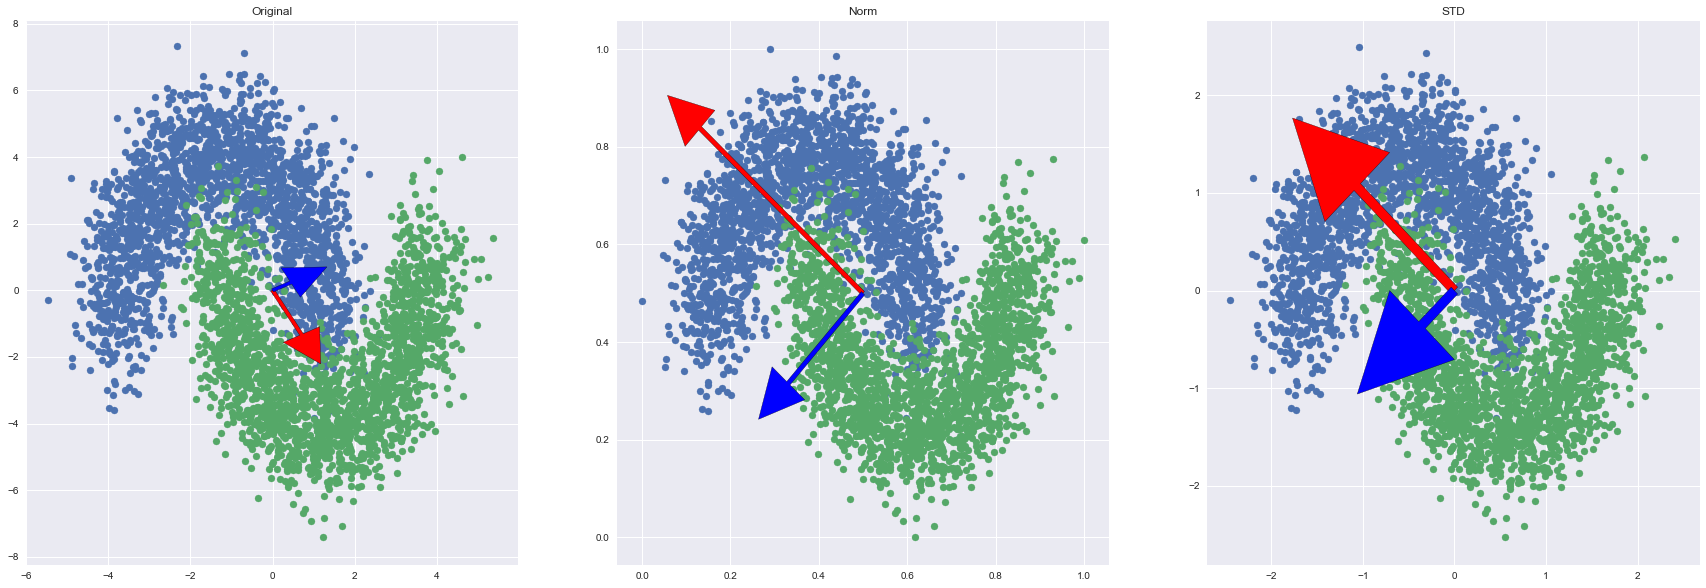

In [126]:
# Make Moons project them
data,label  = datasets.make_moons(n_samples=n_samples,noise=0.2,shuffle=2,random_state=5678)
data[:,0] *= 2.5; data[:,1] *= 5.5
data = data - data.mean(0,keepdims=True)

data_normalized = (data-data.min( 0,keepdims=True))/(data.max(0,keepdims=True)-data.min(0,keepdims=True))
data_std        = (data-data.mean(0,keepdims=True))/(data.std(0,keepdims=True))

og_vec,og_val = pca_svd(data)
no_vec,no_val = pca_svd(data_normalized,mmax=0.5,mmin=0.25)
st_vec,st_val = pca_svd(data_std)

plt.figure(figsize=(30,10))
plt.subplot(131); 
plt.scatter(data[label==0,0],data[label==0,1]);           plt.scatter(data[label==1,0],data[label==1,1]); plt.title('Original')
plt.arrow(0,0,*og_vec[:,0]*og_val[0],length_includes_head = False,color='Red',  ec="k", head_width=1, head_length=1,width=0.1);                   
plt.arrow(0,0,*og_vec[:,1]*og_val[1],length_includes_head = False,color='Blue', ec="k", head_width=1, head_length=1,width=0.1);

plt.subplot(132); 
plt.scatter(data_normalized[label==0,0],data_normalized[label==0,1]); plt.scatter(data_normalized[label==1,0],data_normalized[label==1,1]); plt.title('Norm')
plt.arrow(0.5,0.5,*no_vec[:,0]*no_val[0],length_includes_head = False,color='Red',  ec="k", head_width=0.1, head_length=0.1,width=0.01);                   
plt.arrow(0.5,0.5,*no_vec[:,1]*no_val[1],length_includes_head = False,color='Blue', ec="k", head_width=0.1, head_length=0.1,width=0.01);

plt.subplot(133); 
plt.scatter(data_std[label==0,0],data_std[label==0,1]); plt.scatter(data_std[label==1,0],data_std[label==1,1]); plt.title('STD')
plt.arrow(0,0,*st_vec[:,0]*st_val[0],length_includes_head = False,color='Red',  ec="k", head_width=1, head_length=1,width=0.1);                   
plt.arrow(0,0,*st_vec[:,1]*st_val[1],length_includes_head = False,color='Blue', ec="k", head_width=1, head_length=1,width=0.1);

plt.show()

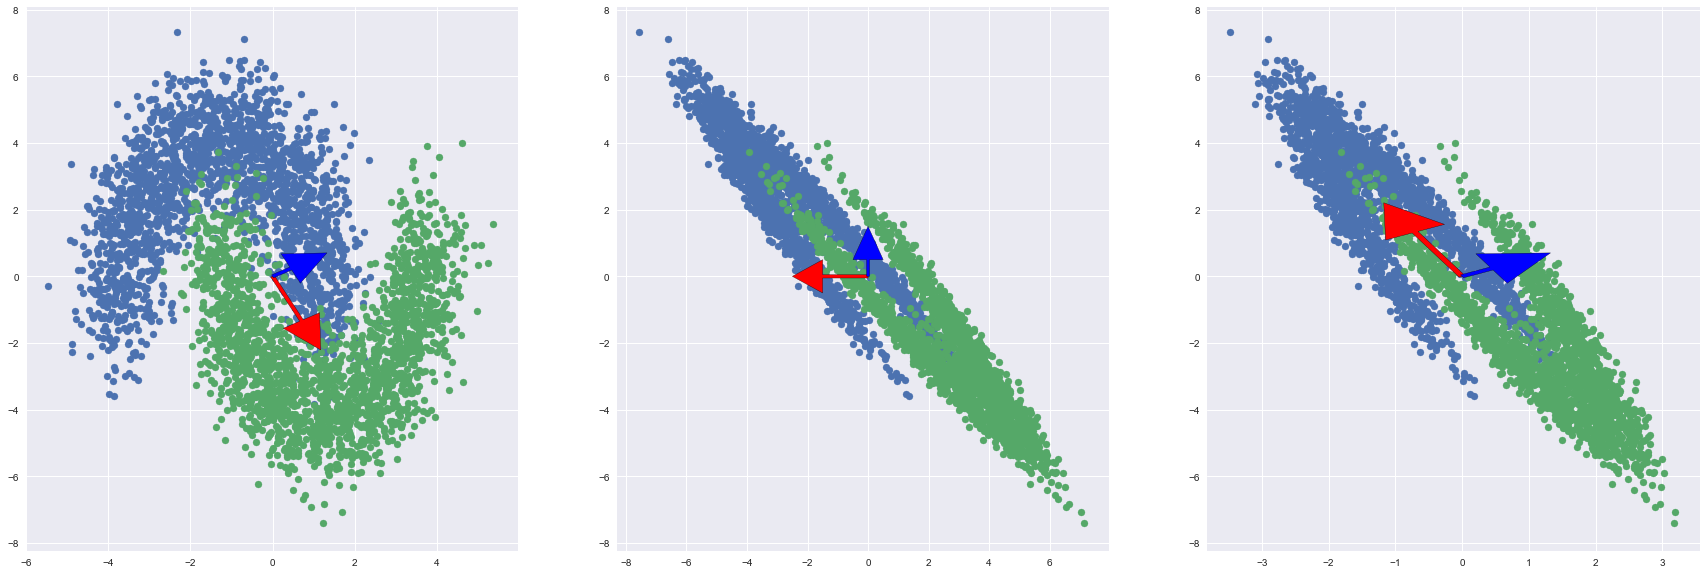

In [127]:
# now fun with pca 
og_vec, og_val = pca_svd(data)

projected_data = data @ og_vec
pj_vec,pj_val  = pca_svd(projected_data)

og_vec_value   = og_vec * og_val
og_vec_mean    = og_vec * og_vec_value.std(0,keepdims=True)

reconstructdata= projected_data @ og_vec_mean.T
rc_vec,rc_val  = pca_svd(reconstructdata)

plt.figure(figsize=(30,10))
plt.subplot(131); 
plt.scatter(data[label==0,0],data[label==0,1]);     
plt.scatter(data[label==1,0],data[label==1,1])
plt.arrow(0,0,*og_vec[:,0]*og_val[0],length_includes_head = False,color='Red',  ec="k", head_width=1, head_length=1,width=0.1);                   
plt.arrow(0,0,*og_vec[:,1]*og_val[1],length_includes_head = False,color='Blue', ec="k", head_width=1, head_length=1,width=0.1);

plt.subplot(132); 
plt.scatter(projected_data[label==0,0],data[label==0,1]); plt.scatter(projected_data[label==1,0],data[label==1,1])
plt.arrow(0,0,*pj_vec[:,0]*pj_val[0],length_includes_head = False,color='Red',  ec="k", head_width=1, head_length=1,width=0.1);                   
plt.arrow(0,0,*pj_vec[:,1]*pj_val[1],length_includes_head = False,color='Blue', ec="k", head_width=1, head_length=1,width=0.1);

plt.subplot(133); 
plt.scatter(reconstructdata[label==0,0],data[label==0,1]); plt.scatter(reconstructdata[label==1,0],data[label==1,1])
plt.arrow(0,0,*rc_vec[:,0]*rc_val[0],length_includes_head = False,color='Red',  ec="k", head_width=1, head_length=1,width=0.1);                   
plt.arrow(0,0,*rc_vec[:,1]*rc_val[1],length_includes_head = False,color='Blue', ec="k", head_width=1, head_length=1,width=0.1);

plt.show()

# ==========================================================================================================

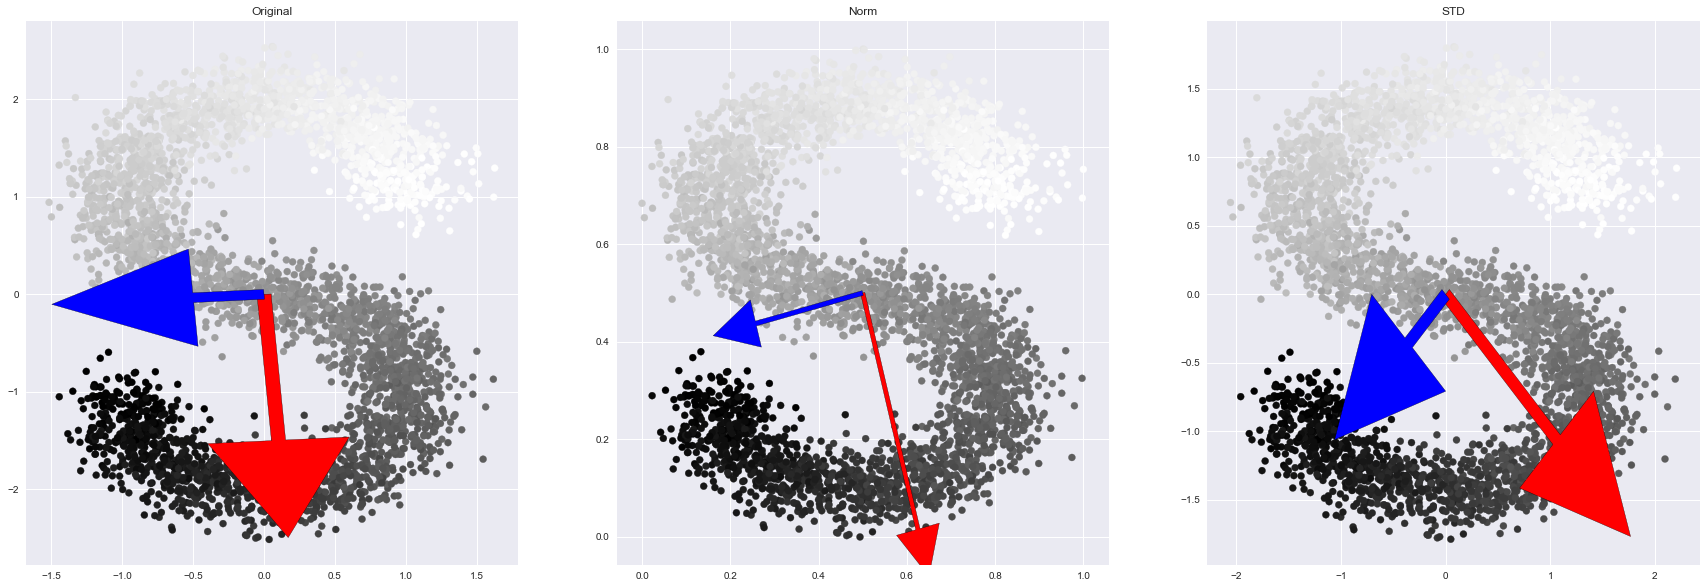

In [128]:
# The S Shaped Data
data,label  = datasets.make_s_curve(n_samples=n_samples,noise=0.2,random_state=5678)
data = np.vstack([data[:,0],data[:,2]]).T
data = data - data.mean(0,keepdims=True)

data_normalized = (data-data.min( 0,keepdims=True))/(data.max(0,keepdims=True)-data.min(0,keepdims=True))
data_std        = (data-data.mean(0,keepdims=True))/(data.std(0,keepdims=True))

og_vec,og_val = pca_svd(data)
no_vec,no_val = pca_svd(data_normalized,mmax=0.5,mmin=0.25)
st_vec,st_val = pca_svd(data_std)

plt.figure(figsize=(30,10))
plt.subplot(131); 
plt.scatter(data[:,0],data[:,1],c=label);                       plt.title('Original')
plt.arrow(0,0,*og_vec[:,0]*og_val[0],length_includes_head = False,color='Red',  ec="k", head_width=1, head_length=1,width=0.1);                   
plt.arrow(0,0,*og_vec[:,1]*og_val[1],length_includes_head = False,color='Blue', ec="k", head_width=1, head_length=1,width=0.1);

plt.subplot(132); 
plt.scatter(data_normalized[:,0],data_normalized[:,1],c=label); plt.title('Norm')
plt.arrow(0.5,0.5,*no_vec[:,0]*no_val[0],length_includes_head = False,color='Red',  ec="k", head_width=0.1, head_length=0.1,width=0.01);                   
plt.arrow(0.5,0.5,*no_vec[:,1]*no_val[1],length_includes_head = False,color='Blue', ec="k", head_width=0.1, head_length=0.1,width=0.01);

plt.subplot(133); 
plt.scatter(data_std[:,0],data_std[:,1],c=label);               plt.title('STD')
plt.arrow(0,0,*st_vec[:,0]*st_val[0],length_includes_head = False,color='Red',  ec="k", head_width=1, head_length=1,width=0.1);                   
plt.arrow(0,0,*st_vec[:,1]*st_val[1],length_includes_head = False,color='Blue', ec="k", head_width=1, head_length=1,width=0.1);

plt.show()

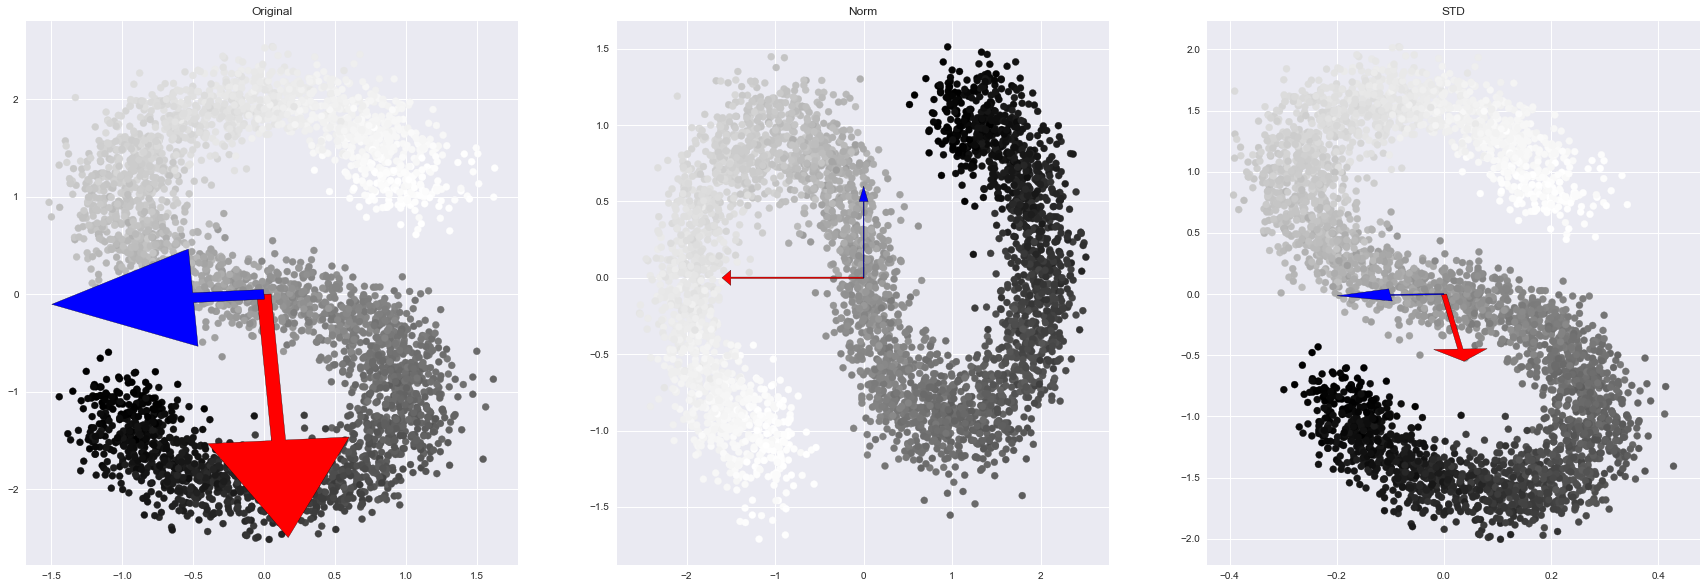

In [137]:
# now fun with pca 
og_vec, og_val = pca_svd(data)

projected_data = data @ og_vec
pj_vec,pj_val  = pca_svd(projected_data)

og_vec_recon   = og_vec * og_val
og_vec_recon   = og_vec * og_vec_recon.std(0,keepdims=True)

reconstructdata= projected_data @ og_vec_recon.T
rc_vec,rc_val  = pca_svd(reconstructdata,mmax=0.45,mmin=0.1)

plt.figure(figsize=(30,10))
plt.subplot(131); 
plt.scatter(data[:,0],data[:,1],c=label);                       plt.title('Original')
plt.arrow(0,0,*og_vec[:,0]*og_val[0],length_includes_head = False,color='Red',  ec="k", head_width=1, head_length=1,width=0.1);                   
plt.arrow(0,0,*og_vec[:,1]*og_val[1],length_includes_head = False,color='Blue', ec="k", head_width=1, head_length=1,width=0.1);

plt.subplot(132); 
plt.scatter(projected_data[:,0],projected_data[:,1],c=label); plt.title('Norm')
plt.arrow(0,0,*pj_vec[:,0]*pj_val[0],length_includes_head = False,color='Red',  ec="k", head_width=0.1, head_length=0.1,width=0.01);                   
plt.arrow(0,0,*pj_vec[:,1]*pj_val[1],length_includes_head = False,color='Blue', ec="k", head_width=0.1, head_length=0.1,width=0.01);

plt.subplot(133); 
plt.scatter(reconstructdata[:,0],reconstructdata[:,1],c=label);               plt.title('STD')
plt.arrow(0,0,*rc_vec[:,0]*rc_val[0],length_includes_head = False,color='Red',  ec="k", head_width=0.1, head_length=0.1,width=0.01);                   
plt.arrow(0,0,*rc_vec[:,1]*rc_val[1],length_includes_head = False,color='Blue', ec="k", head_width=0.1, head_length=0.1,width=0.01);

plt.show()

# ==========================================================================================================

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'nbAgg' by the following code:
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado

<IPython.core.display.Javascript object>


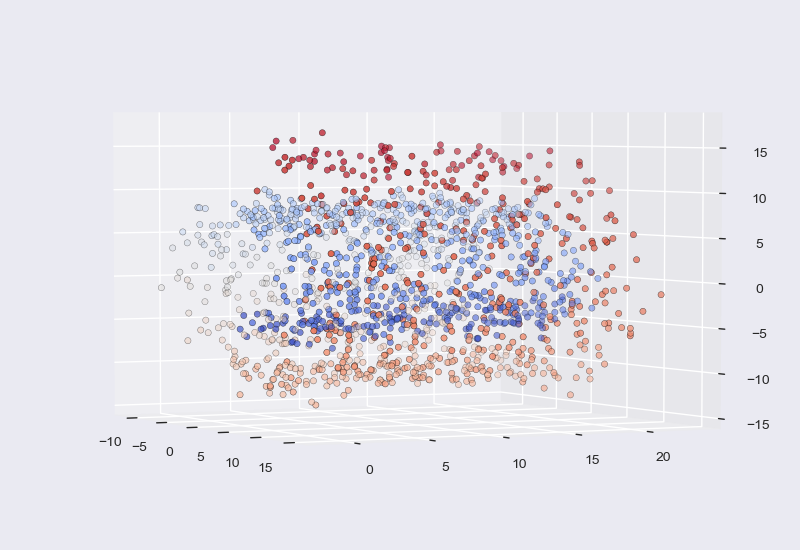

In [163]:
# use the 3D roll with noise
from sklearn.datasets.samples_generator import make_swiss_roll
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import cm
%matplotlib notebook
X, c= make_swiss_roll(n_samples, noise = 1)
fig = plt.figure()
ax  = p3.Axes3D(fig)
ax.view_init(7, -80)
ax.scatter(X[:,0], X[:,1], X[:,2],c=c,s=20, edgecolor='k',cmap=cm.coolwarm)

In [79]:
IFrame('https://www.youtube.com/embed/hxGF7cPvs_c', width=700, height=350)

In [80]:
IFrame('https://www.youtube.com/embed/6lc6Oz0k9WA', width=700, height=350)

# Good link for robust pca

<a href="https://www.youtube.com/watch?v=hxGF7cPvs_c">one</a>
<a href="https://www.youtube.com/watch?v=DK8RTamIoB8">two</a>
<a href="https://www.youtube.com/watch?v=hxGF7cPvs_c">three</a>
<a href="https://www.youtube.com/watch?v=d0bCO_ECkVo">four</a>
<a href="https://www.youtube.com/watch?v=6lc6Oz0k9WA">five</a>

1. https://www.youtube.com/watch?v=6lc6Oz0k9WA
2. https://www.youtube.com/watch?v=d0bCO_ECkVo
3. https://www.youtube.com/watch?v=hxGF7cPvs_c
4. https://www.youtube.com/watch?v=DK8RTamIoB8
5. https://www.youtube.com/watch?v=hxGF7cPvs_c

# Reference

<br>


1. tf.set_random_seed | TensorFlow. (2018). TensorFlow. Retrieved 28 October 2018, from https://www.tensorflow.org/api_docs/python/tf/set_random_seed
2. Comparing different hierarchical linkage methods on toy datasets — scikit-learn 0.20.0 documentation. (2018). Scikit-learn.org. Retrieved 28 October 2018, from http://scikit-learn.org/stable/auto_examples/cluster/plot_linkage_comparison.html#sphx-glr-auto-examples-cluster-plot-linkage-comparison-py
3. VanderPlas, J. (2018). Multiple Subplots | Python Data Science Handbook. Jakevdp.github.io. Retrieved 28 October 2018, from https://jakevdp.github.io/PythonDataScienceHandbook/04.08-multiple-subplots.html
4. object, M. (2018). Matplotlib returning a plot object. Stack Overflow. Retrieved 28 October 2018, from https://stackoverflow.com/questions/43925337/matplotlib-returning-a-plot-object
5. Plot randomly generated classification dataset — scikit-learn 0.20.0 documentation. (2018). Scikit-learn.org. Retrieved 28 October 2018, from http://scikit-learn.org/stable/auto_examples/datasets/plot_random_dataset.html#sphx-glr-auto-examples-datasets-plot-random-dataset-py
6. 5. Dataset loading utilities — scikit-learn 0.20.0 documentation. (2018). Scikit-learn.org. Retrieved 28 October 2018, from http://scikit-learn.org/stable/datasets/index.html
7. mplot3d tutorial — Matplotlib 2.0.2 documentation. (2018). Matplotlib.org. Retrieved 28 October 2018, from https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html
8. matplotlib, H. (2018). How to plot vectors in python using matplotlib. Stack Overflow. Retrieved 28 October 2018, from https://stackoverflow.com/questions/42281966/how-to-plot-vectors-in-python-using-matplotlib
9. arrow, M. (2018). Matplotlib legend for an arrow. Stack Overflow. Retrieved 28 October 2018, from https://stackoverflow.com/questions/22348229/matplotlib-legend-for-an-arrow
10. plt colors - Google Search. (2018). Google.ca. Retrieved 28 October 2018, from https://www.google.ca/search?q=plt+colors&rlz=1C1CHBF_enCA771CA771&oq=plt+colors&aqs=chrome..69i57j0l5.1038j0j7&sourceid=chrome&ie=UTF-8
11. Brownlee, J. (2018). A Gentle Introduction to Singular-Value Decomposition for Machine Learning. Machine Learning Mastery. Retrieved 28 October 2018, from https://machinelearningmastery.com/singular-value-decomposition-for-machine-learning/
12. https://www.quora.com/Why-do-we-need-to-center-the-data-for-Principle-Components-Analysis
13. ipython-notebook, i. (2018). iframe not rendering in ipython-notebook. Stack Overflow. Retrieved 14 November 2018, from https://stackoverflow.com/questions/17619964/iframe-not-rendering-in-ipython-notebook
14. numpy.random.poisson — NumPy v1.15 Manual. (2018). Docs.scipy.org. Retrieved 14 November 2018, from https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.poisson.html
15. Drawing arrows in Matplotlib. (2012). Lumps 'n' Bumps. Retrieved 14 November 2018, from https://philbull.wordpress.com/2012/04/05/drawing-arrows-in-matplotlib/
16. matplotlib.pyplot.arrow Python Example. (2018). Programcreek.com. Retrieved 14 November 2018, from https://www.programcreek.com/python/example/102342/matplotlib.pyplot.arrow
17. Arrow Demo — Matplotlib 3.0.2 documentation. (2018). Matplotlib.org. Retrieved 14 November 2018, from https://matplotlib.org/gallery/text_labels_and_annotations/arrow_demo.html#sphx-glr-gallery-text-labels-and-annotations-arrow-demo-py
18. 1?, H. (2018). How to normalize data between -1 and 1?. Cross Validated. Retrieved 14 November 2018, from https://stats.stackexchange.com/questions/178626/how-to-normalize-data-between-1-and-1
19. Consistent deprecation of the hold kwarg of hlines and vlines · Issue #8421 · matplotlib/matplotlib. (2018). GitHub. Retrieved 14 November 2018, from https://github.com/matplotlib/matplotlib/issues/8421/
20. t-SNE: The effect of various perplexity values on the shape — scikit-learn 0.20.0 documentation. (2018). Scikit-learn.org. Retrieved 14 November 2018, from https://scikit-learn.org/stable/auto_examples/manifold/plot_t_sne_perplexity.html#sphx-glr-auto-examples-manifold-plot-t-sne-perplexity-py
21. sklearn.datasets.make_s_curve — scikit-learn 0.20.0 documentation. (2018). Scikit-learn.org. Retrieved 14 November 2018, from https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_s_curve.html#sklearn.datasets.make_s_curve
22. 